In [ ]:
#Please delete this block if you don't use Google Colab. Please cd to the script folder. 
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('drive/My Drive/YourFolderName') #Need to change the address to where your script is
os.listdir('.')

Mounted at /content/drive


['output',
 'train.npy',
 'valid.npy',
 'label.npy',
 'test.npy',
 'train_100.npy',
 'train_50.npy',
 'valid_A45.npy',
 'label_A45.npy',
 'test_A45.npy',
 'train_A45.npy',
 'orientation_test.npy',
 'train_A45.ipynb',
 'train_20.npy',
 'train_10.npy',
 'log.csv',
 'model.hdf5',
 'train_5.npy',
 'train.ipynb']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gc
import csv
from skimage import io
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
from tensorflow.keras import backend as keras
from tensorflow.keras.initializers import *
from tensorflow.data import Dataset

In [ ]:
#Load training data and validation data
train = (np.load('train.npy',allow_pickle=True).astype('float32'))*255
label = (np.load('label.npy',allow_pickle=True).astype('float32'))*255
valid = (np.load('valid.npy',allow_pickle=True).astype('float32'))*255
trainSize = train.shape[0]
validSize = valid.shape[0]
labelSize = label.shape[0]
print(trainSize)
print(validSize) 
print(labelSize) 

(589, 61, 256)
(5371, 61, 256)
(5371, 61, 256)


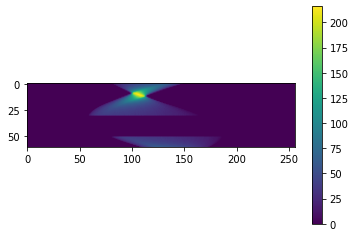

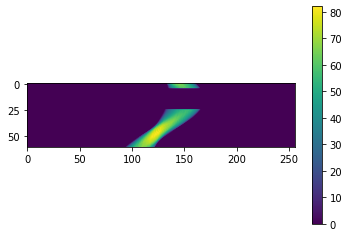

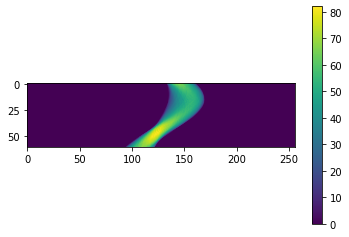

In [ ]:
#Check the training dataset
fig, ax = plt.subplots()
h = ax.imshow(train[5,:,:])
fig.colorbar(h)

fig, ax = plt.subplots()
h = ax.imshow(valid[5,:,:])
fig.colorbar(h)

fig, ax = plt.subplots()
h = ax.imshow(label[5,:,:])
fig.colorbar(h)

In [ ]:
#Function and model defining
def masker(imgs):# The random masking function
	mask = np.ones((imgs.shape[0],61,256)).astype('float32')
	for i in range(mask.shape[0]):
		temp = np.ones((61,256)).astype('float32')
		st = np.random.randint(0,42)
		temp[st:st+20,:] = 0
		mask[i,:,:] = temp
	imgs2 = imgs*mask
	return (imgs2,mask)
 
def get_unet():# Define the U-Net with MSE loss
		inputs = Input((61,256,1))
		padd1 = ZeroPadding2D(padding=((0,3), (0,0)))(inputs)
		conv1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(padd1)
		print ("conv1 shape:",conv1.shape)
		conv1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
		print ("conv1 shape:",conv1.shape)
		pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
		print ("pool1 shape:",pool1.shape)

		conv2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
		print ("conv2 shape:",conv2.shape)
		conv2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
		print ("conv2 shape:",conv2.shape)
		pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
		print ("pool2 shape:",pool2.shape)

		conv3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
		print ("conv3 shape:",conv3.shape)
		conv3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
		print ("conv3 shape:",conv3.shape)
		pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
		print ("pool3 shape:",pool3.shape)

		conv4 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
		conv4 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
		drop4 = Dropout(0.5)(conv4)

		up7 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv4))
		merge7 = concatenate([conv3,up7], axis = 3)
		conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
		conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

		up8 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
		merge8 = concatenate([conv2,up8], axis = 3)
		conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
		conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

		up9 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
		merge9 = concatenate([conv1,up9], axis = 3)
		conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
		conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
		
		conv10 = Conv2D(1, 1, activation = 'linear')(conv9)
		conv10 = Cropping2D(((0,3),(0,0)))(conv10)
		model = Model(inputs = inputs, outputs = conv10)
		model.compile(optimizer = Adam(learning_rate = 5e-6), loss = 'MSE', metrics = 'MSE') 
		return model

In [ ]:
#Model training
model = get_unet()
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='loss',verbose=1, save_best_only=False)
f = open('log.csv', 'w+')
f.close()
model.summary()
epochVolume = 1000 #parameter: how many sinogram images will be included in one epoch
epoch = 200 #parameter: total epoch numbers before training stop
sample_pred = np.random.choice(np.array(range(validSize)),10) # will select 10 random sinogram images in the validation data and output the prediction result every epoch
sample_pred = valid[sample_pred] # will select 10 random sinogram images in the validation data and output the prediction result every epoch
baseline_MSE = np.mean(np.square(valid - label))
baseline_SSIM = tf.image.ssim(valid,label,max_val=255)
baseline_PSNR = tf.image.psnr(valid,label,max_val=255)
print('Baseline MSE: '+str(baseline_MSE) + '; Baseline SSIM: '+str(baseline_SSIM.numpy()) + '; BaselinePSNR: ' + str(baseline_PSNR.numpy()))
for epochs in range(epoch):
  print('Epoch: '+str(epochs)+' 1st predicting')
  sample = np.random.choice(np.array(range(trainSize)),epochVolume) #Randomly sample image in the training dataset
  sample = train[sample] #Randomly sample image in the training dataset
  imgs_1st_predict = model.predict(sample, batch_size=1, verbose=1).squeeze() #Make 1st prediction from the sampled images
  imgs_2nd_masked = masker(imgs_1st_predict)[0] #Mask the 1st predictions
  print('Epoch: '+str(epochs)+' training')
  h = model.fit(imgs_2nd_masked, imgs_1st_predict, batch_size=1, validation_data = (valid, label), epochs=1, verbose=1,  shuffle=True, callbacks=[model_checkpoint]) #Use the 1st predictions and their masked versions for training
  print('Epoch: '+str(epochs)+' 2nd predicting')
  imgs_1st_predict = model.predict(sample_pred, batch_size=2, verbose=1).squeeze() #Try to predict the 10 random sinogram images
  imgs_2nd_predict = model.predict(masker(imgs_1st_predict)[0], batch_size=2, verbose=1).squeeze() #Try to predict the masked 10 random sinogram images
  print('Epoch: '+str(epochs)+' saving montages')
  opt1 = np.concatenate((np.concatenate((imgs_1st_predict[:5]),axis = 1) , np.concatenate((imgs_1st_predict[5:]),axis = 1)) , axis = 0)
  opt2 = np.concatenate((np.concatenate((imgs_2nd_predict[:5]),axis = 1) , np.concatenate((imgs_2nd_predict[5:]),axis = 1)) , axis = 0)
  opt1[opt1<0] = 0
  opt1[opt1>255] = 255
  opt2[opt2<0] = 0
  opt2[opt2>255] = 255
  opt1 = opt1.astype('uint8')
  opt2 = opt2.astype('uint8')
  cv2.imwrite('output/1st/'+str(epochs)+'.png', opt1 ) #Write the predictions of the 10 random sinogram images
  cv2.imwrite('output/2nd/'+str(epochs)+'.png', opt2 ) #Write the predictions of the masked predictions of the 10 random sinogram images
  _ = gc.collect()
  tf.keras.backend.clear_session()
  f = open('log.csv', 'a')
  writer = csv.writer(f)
  writer.writerow( [h.history['MSE'][0],h.history['val_MSE'][0],baseline_MSE] )
  f.close()

conv1 shape: (None, 64, 256, 128)
conv1 shape: (None, 64, 256, 128)
pool1 shape: (None, 32, 128, 128)
conv2 shape: (None, 32, 128, 256)
conv2 shape: (None, 32, 128, 256)
pool2 shape: (None, 16, 64, 256)
conv3 shape: (None, 16, 64, 512)
conv3 shape: (None, 16, 64, 512)
pool3 shape: (None, 8, 32, 512)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 61, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 64, 256, 1)  0           ['input_1[0][0]']                
                                                                                          

In [ ]:
#Predict the validation data and print the SSIM and PSNR
print('Predicting validation data')
predictions = model.predict(valid, batch_size=2, verbose=1)
SSIM = tf.image.ssim(predictions[:,:,:,0],label,max_val=255)
PSNR = tf.image.psnr(predictions[:,:,:,0],label,max_val=255)
print(SSIM)
print(PSNR)

Network Loaded
Predicting test data
2686/2686 [==============================] - 15s 5ms/step
tf.Tensor(0.8729205, shape=(), dtype=float32)
tf.Tensor(4.618717, shape=(), dtype=float32)


In [ ]:
#Make prediction for test data. Test data are sinogram image stacks instead of single sinograms.
test= (np.load('test.npy',allow_pickle=True).astype('float32'))*255
itr = 1
for tilt in test:
  predictions = model.predict(tilt, batch_size=2, verbose=1)
  predictions[predictions<0] = 0
  predictions[predictions>255] = 255
  io.imsave('output/test_pred/'+str(itr)+'.tif', predictions.squeeze()/255  )
  itr = itr+1

128/128 [==============================] - 1s 5ms/step
